# Image Classification of ATLAS Calorimeter Topo-Clusters

The performance of different Machine Learning techniques for classifying topological clusters in the ATLAS caporimeter are compared. 

### The task

Train a classifier to determine which type of particle generated the cluster (e.g. $e^{\pm}$ vs. $\pi^{\pm}$ or $\pi^0$ vs. $\pi^{\pm}$).

### The cluster images

Each cluster is associated with six 2D images, corresponding to the barrels layers of the EM (EMB1, EMB2, EMB3) and HAD (TileBar0, TileBar2, TileBar3) calorimeter. Normalized calorimeter cell energies are used as pixel values. The image size is $0.4\times0.4$ in $\eta\times\phi$ space.

The following models are implemented:

- Simple fully-connected Neural Network (flattening the images and only using the 512 pixels in the EMB1 layer).
- A deeper Convolutional Neural Network (preserving the shape of the 2D images).

TODO
- Also compare the performance of: logistic regression, SVD, Naive Bias, Gaussians, etc.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

## Import the datasets 

The notebook is structured to make the swapping of datasets trivial. 

In [2]:
# import electron vs. pion images (pt = 100 GeV)

elec = np.load("../datasets/images_electron_100_v01-4-g1135c42.npz")
pion = np.load("../datasets/images_pion_100_v01-4-g1135c42.npz")

nelec = len(elec['EMB1'])
npion = len(pion['EMB1'])
print("Number of electron events: {}".format(nelec))
print("Number of pion events: {}".format(npion))
print("Total: {}".format(nelec+npion))

Number of electron events: 11741
Number of pion events: 10968
Total: 22709


In [3]:
# import pi+- vs. pi0 images

#nmax = 20000
# TODO fix input files so that it is easier to split up the events
p0 = np.load("../datasets/images_pi0_v01-6-g20e4c51.npz")
pp = np.load("../datasets/images_piplus_v01-6-g20e4c51.npz")
pm = np.load("../datasets/images_piminus_v01-6-g20e4c51.npz")

np0 = len(p0['EMB1'])
npp = len(pp['EMB1'])
npm = len(pm['EMB1'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 325485
Number of pi+ events: 78634
Number of pi- events: 77287
Total: 481406


### Plot a few example images

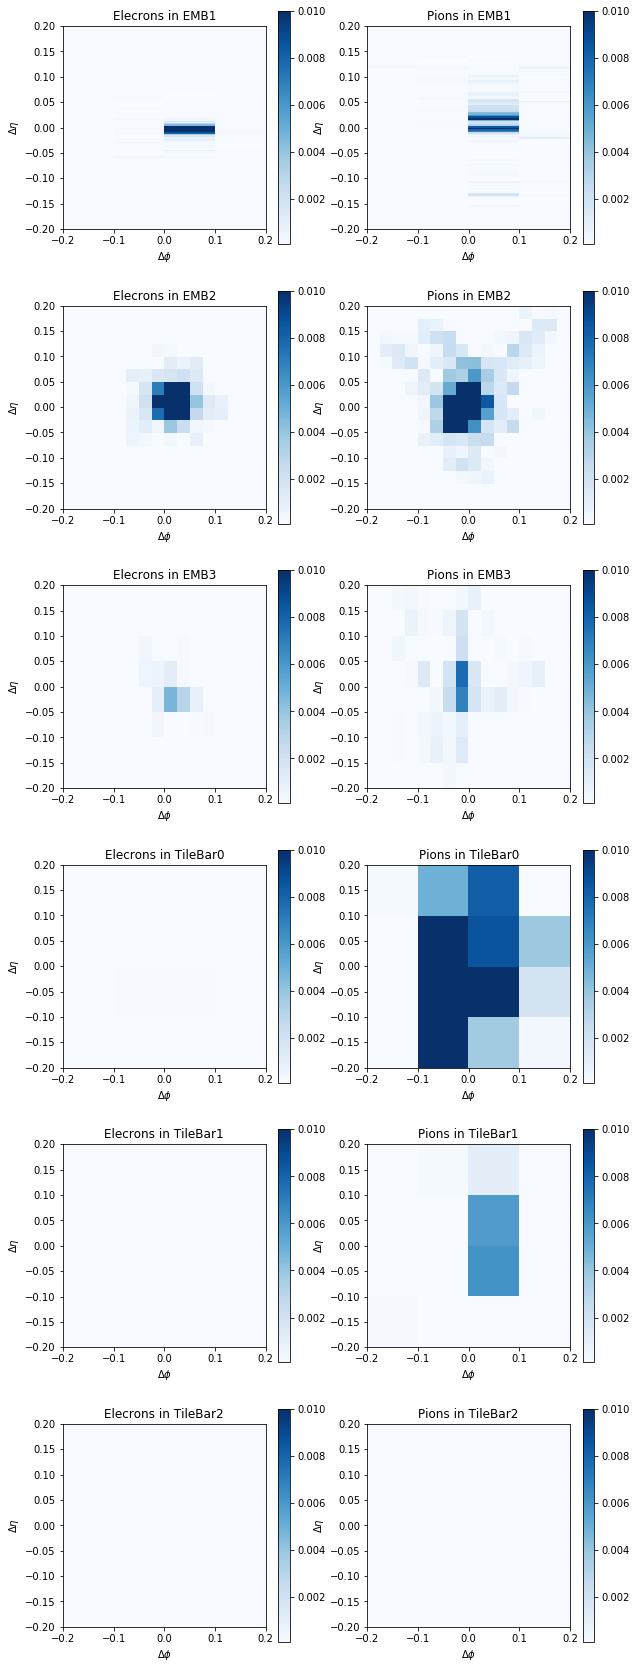

In [4]:
# plots for pT = 100 GeV electron/pion samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 150

# make the plot
plt.cla(); plt.clf()
plt.figure(figsize=(10,30))

i = 1
for layer in layers:
    
    # electrons
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(elec[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Elecrons in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

    # charged pions
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(pion[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Pions in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.show()

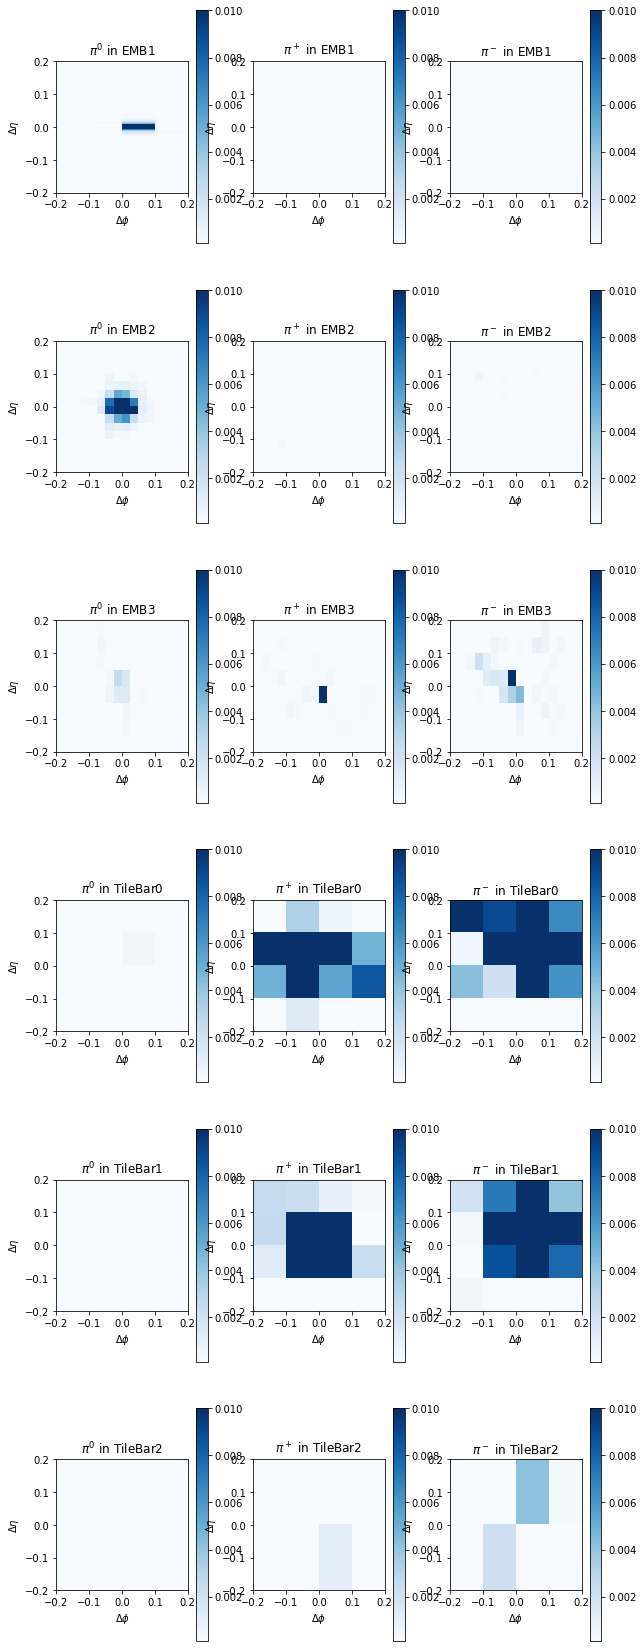

In [5]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 0

# make the plot
plt.cla(); plt.clf()
plt.figure(figsize=(10,30))

i = 1
for layer in layers:
    
    # pi0
    plt.subplot(6,3,i)
    i += 1
    plt.imshow(p0[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('$\pi^0$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

    # pi+
    plt.subplot(6,3,i)
    i += 1
    plt.imshow(pp[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('$\pi^+$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")
    
    # pi-
    plt.subplot(6,3,i)
    i += 1
    plt.imshow(pm[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('$\pi^-$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.show()

### Plot a few histograms

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


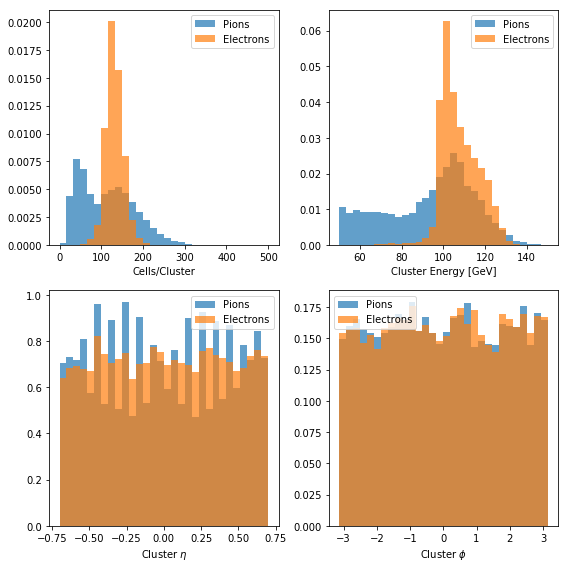

In [6]:
# histograms for pT = 100 GeV electron/pion samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(8,8))

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Pions')
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Electrons')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Pions')
ax[0,1].hist(elec['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Electrons')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,0].hist(elec['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()

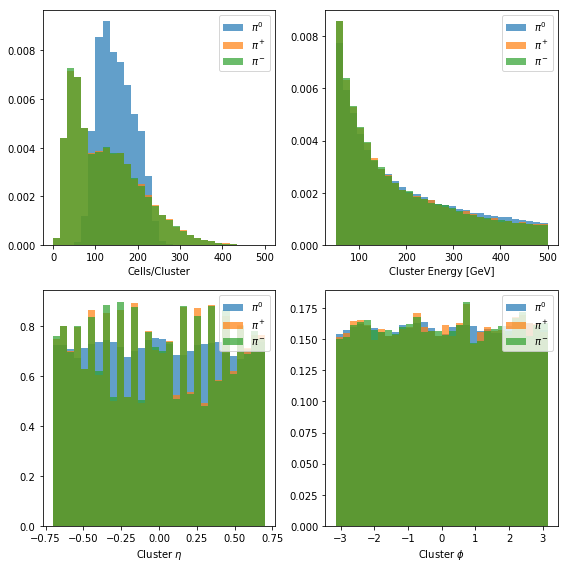

In [7]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(8,8))

# number of cells per cluster
ax[0,0].hist(p0['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^0$')
ax[0,0].hist(pp['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^+$')
ax[0,0].hist(pm['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^-$')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(p0['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^0$')
ax[0,1].hist(pp['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^+$')
ax[0,1].hist(pm['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^-$')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(p0['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,0].hist(pp['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,0].hist(pm['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(p0['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,1].hist(pp['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,1].hist(pm['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()

## 1. Simple feed-forward Neural Network

In [14]:
# Train on pT = 100 GeV electron/pion samples

# only include the EMB1 layer, flattened
layer = layers[0]
num_pixels = int(len_phi[0]*len_eta[0])

X = np.append(elec[layer].reshape((len(elec[layer]),num_pixels)),
              pion[layer].reshape((len(pion[layer]),num_pixels)), axis=0)

y = np.append(elec['label'], pion['label'], axis=0)

print (X.shape)
print (y.shape)

(22709, 512)
(22709, 1)


In [9]:
# Train on E = 0.5-2000 GeV pi0/pi+/pi- samples

# only include the EMB1 layer, flattened
layer = layers[0]
num_pixels = int(len_phi[0]*len_eta[0])

sample_size = 25000 
X = np.append(p0[layer][0:sample_size].reshape((sample_size,num_pixels)),
               pp[layer][0:sample_size].reshape((sample_size,num_pixels)), axis=0)

y = np.append(p0['label'][0:sample_size], pp['label'][0:sample_size], axis=0)

print (X.shape)
print (y.shape)

(50000, 512)
(50000, 1)


In [15]:
# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.cross_validation import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X_tr = X_tr / 255
X_te = X_te / 255
X_vl = X_vl / 255

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr)
y_te_onehot = np_utils.to_categorical(y_te)
y_vl_onehot = np_utils.to_categorical(y_vl)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

('y_train.shape: ', (17709, 1))
('y_train_onehot.shape: ', (17709, 2))


In [11]:
from keras.models import Sequential
from keras.layers import Dense

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
# build the model
model = baseline_model()
model.summary()

from keras.utils import to_categorical
y_tr_onehot = to_categorical(y_tr)
y_te_onehot = to_categorical(y_te)
y_vl_onehot = to_categorical(y_vl)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 427,138
Trainable params: 427,138
Non-trainable params: 0
_________________________________________________________________


In [17]:
# fit (train) the model
history = model.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=50, batch_size=200, verbose=2)

# final evaluation of the model
scores = model.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 17709 samples, validate on 1000 samples
Epoch 1/50
 - 1s - loss: 0.6927 - acc: 0.5161 - val_loss: 0.6932 - val_acc: 0.5010
Epoch 2/50
 - 1s - loss: 0.6927 - acc: 0.5171 - val_loss: 0.6936 - val_acc: 0.5010
Epoch 3/50
 - 1s - loss: 0.6927 - acc: 0.5171 - val_loss: 0.6933 - val_acc: 0.5010
Epoch 4/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6939 - val_acc: 0.5010
Epoch 5/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6941 - val_acc: 0.5010
Epoch 6/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6939 - val_acc: 0.5010
Epoch 7/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6936 - val_acc: 0.5010
Epoch 8/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6938 - val_acc: 0.5010
Epoch 9/50
 - 1s - loss: 0.6927 - acc: 0.5171 - val_loss: 0.6936 - val_acc: 0.5010
Epoch 10/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 11/50
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 12/50
 - 1s - loss: 0.6926 - a

['acc', 'loss', 'val_acc', 'val_loss']


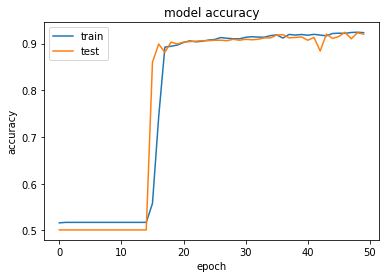

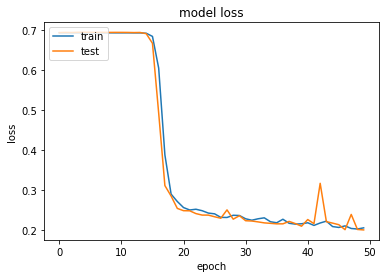

In [18]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_te)
fpr, tpr, thres = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc = auc(fpr, tpr)
print("Area under curve: {}".format(auc))

Area under curve: 0.973285342661


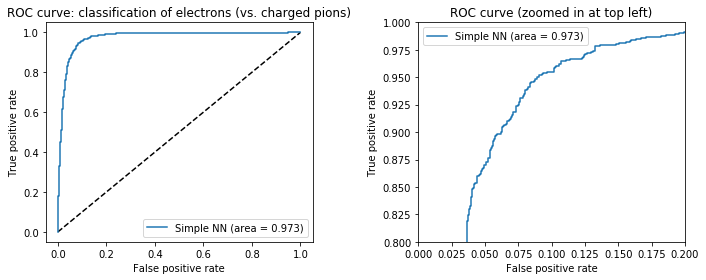

In [20]:


plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))

ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr, tpr, label='Simple NN (area = {:.3f})'.format(auc))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of electrons (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr, tpr, label='Simple NN (area = {:.3f})'.format(auc))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()

## 2. Convolutional Neural Network

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)